In [48]:
import pandas as pd
import numpy as np
import datetime, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import random

In [49]:
def get_unix(latency):
    millisecond = datetime.datetime.now() - datetime.timedelta(seconds=latency)
    unixtimestamp = int(millisecond.timestamp() * 1000)
    return unixtimestamp

In [50]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

In [52]:
df = pd.read_csv("Data/data_drift_20.csv",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'latency': pd.Series(dtype='float'),
                   'drift': pd.Series(dtype='int')})

In [53]:
def calc_metric(driftTime, detectTime, threshold, false_alarm_threshold=5):
    
    tsDrift = datetime.datetime.fromtimestamp(int(driftTime)/1000)  
    tsDetect = datetime.datetime.fromtimestamp(int(detectTime)/1000)  
    diff = tsDetect - tsDrift
    diff = diff.total_seconds()
    if diff > 0 and diff <= threshold:
        return "TP"
    elif diff > 0 and diff> threshold and diff<false_alarm_threshold:
        return "FN"
    return "FP"
    

In [54]:
df.head()

,ingestion,event,latency,drift
0,1658333937152,1658333934104,3.048357,0
1,1658333937167,1658333934436,2.730868,0
2,1658333937181,1658333934057,3.123844,0
3,1658333937195,1658333933633,3.561515,0
4,1658333937210,1658333934527,2.682923,0


In [55]:
def evaluate(threshold, df_p):
    TOTAL_DRIFT= 20
    detectedTS = df_p["ingestion"].tolist()
    driftsTS = df.query("drift == 1")["ingestion"].tolist()

    result= dict()
    result["name"] =  df_p["algorithm"].unique()[0]
    result["predictedDrift"] = len(detectedTS)
    result["TP"]=0 # should be drift  and it is in threshold
    result["FN"]=0 # should be drift it is not in threshold
    result["FP"]=0 # should not be drift (false alarm)
   
    
    
    
    for index,ingestion in enumerate(driftsTS):
        total_drift = len(driftsTS)
        
        first_drift = driftsTS[index]
        if index < total_drift-1:
            second_drift = driftsTS[index+1]
        else:
            second_drift = 9999999999999
        first_accepted = False # it can be 2 predictions within a period
        for j in detectedTS:
            if j > first_drift and j < second_drift:
                metric = calc_metric(ingestion, j, threshold)
                
                if metric == "TP":
                    result["TP"] += 1
                    first_accepted = True
                else:
                    if metric == "FP":
                        result["FP"] += 1
                    elif first_accepted:
                        result["FP"] += 1
                    elif metric == "FN":
                        result["FN"] += 1
                    else:
                        print("NA")
        

    
    return result

In [56]:
files = ["result_sudden_ADWIN.csv","result_sudden_GMADM.csv", "result_sudden_CUSUM.csv", "result_sudden_PageHinkley.csv"]

In [57]:
thresholds = [0.50,0.75, 1.25, 1.75]
df_result = pd.DataFrame({'algorithm': pd.Series(dtype='str'),'threshold': pd.Series(dtype='int'),
                   'predictedDrift': pd.Series(dtype='int'),
                          'TP': pd.Series(dtype='int'),'FP': pd.Series(dtype='int'),
                          'FN': pd.Series(dtype='float'),
                           'Sensitivity': pd.Series(dtype='float'),
                         'Precision': pd.Series(dtype='float'),})


for f in files:
    df_processed = pd.read_csv(f"Result/{f}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
    
    
    for t in thresholds:
        result = evaluate(t, df_processed)
        try:
            precision = result["TP"]/ ( result["TP"] + result["FP"])
        except:
            precision: 0
        df_result = df_result.append({"algorithm":result["name"] ,"threshold": t, "TP": result["TP"],
                                      "FP":result["FP"],  "FN": result["FN"],
                                      "predictedDrift": result["predictedDrift"],
                                     "Sensitivity": result["TP"]/ (result["TP"] + result["FN"]),
                                     "Precision": precision, },ignore_index=True) 

In [58]:
df_result

,algorithm,threshold,predictedDrift,TP,FP,FN,Sensitivity,Precision
0,ADWIN,0.50,20,18,0,2.0,0.90,1.000000
1,ADWIN,0.75,20,20,0,0.0,1.00,1.000000
2,ADWIN,1.25,20,20,0,0.0,1.00,1.000000
3,ADWIN,1.75,20,20,0,0.0,1.00,1.000000
4,GMADM,0.50,4,0,0,4.0,0.00,1.000000
5,GMADM,0.75,4,1,0,3.0,0.25,1.000000
6,GMADM,1.25,4,3,0,1.0,0.75,1.000000
7,GMADM,1.75,4,3,0,1.0,0.75,1.000000
8,CUSUM,0.50,11,8,1,2.0,0.80,0.888889
9,CUSUM,0.75,11,8,1,2.0,0.80,0.888889


In [59]:
def print_latex(data):
    data = list(data.to_dict(orient="records"))
    for i in data:
        precision= "{:.2f}".format(i["Precision"])
        missed_prediction = int(20-i["TP"]-i["FN"])
        print(f'{i["algorithm"]}  & {i["threshold"]}  & {i["predictedDrift"]} & {i["TP"]} & {i["FP"]} & { int(i["FN"])} & {missed_prediction} & {i["Sensitivity"]} & {precision}  \\\ \hline') 

In [60]:
print_latex(df_result)

ADWIN  & 0.5  & 20 & 18 & 0 & 2 & 0 & 0.9 & 1.00  \\ \hline
ADWIN  & 0.75  & 20 & 20 & 0 & 0 & 0 & 1.0 & 1.00  \\ \hline
ADWIN  & 1.25  & 20 & 20 & 0 & 0 & 0 & 1.0 & 1.00  \\ \hline
ADWIN  & 1.75  & 20 & 20 & 0 & 0 & 0 & 1.0 & 1.00  \\ \hline
GMADM  & 0.5  & 4 & 0 & 0 & 4 & 16 & 0.0 & 1.00  \\ \hline
GMADM  & 0.75  & 4 & 1 & 0 & 3 & 16 & 0.25 & 1.00  \\ \hline
GMADM  & 1.25  & 4 & 3 & 0 & 1 & 16 & 0.75 & 1.00  \\ \hline
GMADM  & 1.75  & 4 & 3 & 0 & 1 & 16 & 0.75 & 1.00  \\ \hline
CUSUM  & 0.5  & 11 & 8 & 1 & 2 & 10 & 0.8 & 0.89  \\ \hline
CUSUM  & 0.75  & 11 & 8 & 1 & 2 & 10 & 0.8 & 0.89  \\ \hline
CUSUM  & 1.25  & 11 & 10 & 1 & 0 & 10 & 1.0 & 0.91  \\ \hline
CUSUM  & 1.75  & 11 & 10 & 1 & 0 & 10 & 1.0 & 0.91  \\ \hline
PageHinkley  & 0.5  & 4 & 1 & 2 & 1 & 18 & 0.5 & 0.33  \\ \hline
PageHinkley  & 0.75  & 4 & 1 & 2 & 1 & 18 & 0.5 & 0.33  \\ \hline
PageHinkley  & 1.25  & 4 & 1 & 2 & 1 & 18 & 0.5 & 0.33  \\ \hline
PageHinkley  & 1.75  & 4 & 1 & 2 & 1 & 18 & 0.5 & 0.33  \\ \hline


In [64]:
def plot_drifts(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"Result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        algorithm = df_processed["algorithm"].unique()[0]
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.set_title(algorithm)
        ax1.plot(df["latency"], label='Stream')

        driftsExtra = df_processed["indexNumber"].tolist()
        """
        drifts= list(df.query("drift == 1").index)
        if len(drifts) > 0:
            for i in drifts:
                ax1.axvline(i, color='red')
        """
        for i in driftsExtra:
            ax1.axvline(i, color='orange')
    #plt.xlim([800, 1200])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

In [65]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

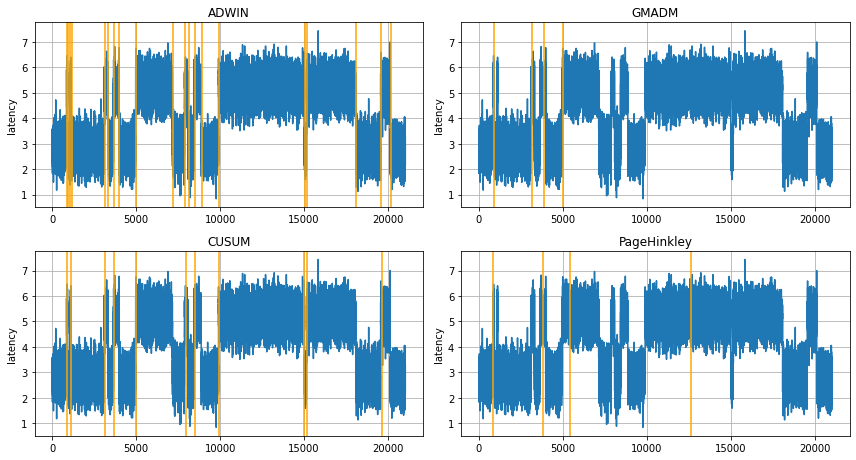

In [66]:
plot_drifts(df,files, "drift_result_plots.png")

In [46]:
def plot_drifts_ex(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"conceptdrift/Data/result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.set_xlabel('ingestion unix timestamp')
        ax1.plot(df["ingestion"],df["latency"], label='Stream')

        driftsExtra = df_processed["ingestion"].tolist()
        
        drifts= df.query("drift == 1")
        if drifts.shape[0] > 0:
            for index, row in drifts.iterrows():
                ax1.axvline(int(row["ingestion"]), color='red')
       
        for i in driftsExtra:
            ax1.axvline(int(i), color='orange')
        
    plt.xlim([1658333948701, 1658333951107])
    
    #plt.ylim([0, 7])
    red_patch = mpatches.Patch(color='red', label='actual drift')
    orange_patch = mpatches.Patch(color='orange', label='predicted drift')
    plt.legend(handles=[red_patch,orange_patch])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

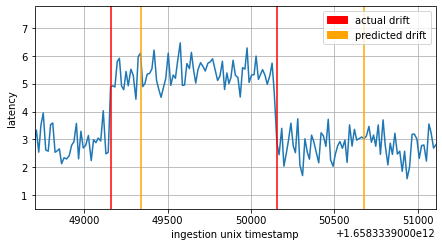

In [47]:
plot_drifts_ex(df,["result_sudden_ADWIN.csv"])